# ポアソン分布とPythonでPB法を使った検定を復習してみた

## 課題の設定

■変数の定義  
y: 植物の種のような自然数の測定値  
x: 植物の大きさのような連続量の測定値  
d: 追肥のような手続きの有り無し(0,1)  

■課題  
植物の種子数yが、その植物のサイズxと追肥の有り無しdと相関があるのか否かをt検定で判定

■正解のポアソン分布の変数lam(=λ)(観測者は知らない)

In [1]:
import numpy as np
def lam(x,d):
    return np.exp(2 + 0.2*x +0*d)

## サンプルの作成

サンプルを100個作成  
各サンプルに対してy,x,dの観測値がある

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
np.random.seed(seed=4)

sample_number = 100

# 植物の大きさのデータ作成
x = np.random.normal(loc   = 0,      # 平均
                     scale = 1,      # 標準偏差
                     size  = sample_number,# 出力配列のサイズ(タプルも可)
                    )

# 追肥の有り無しの作成
d = np.random.rand(sample_number)
d = np.where(d>0.5,1,0).astype("float")

# ポアソン分布に従う種子数の作成
y = np.random.poisson(lam=lam(x,d)).astype("float")

print(x.shape,d.shape,y.shape)

(100,) (100,) (100,)


### サンプルの分布の確認

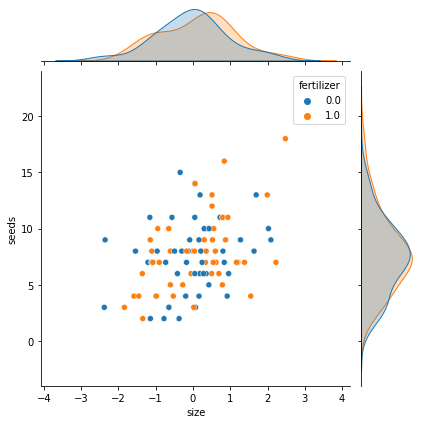

In [4]:
df = pd.DataFrame(np.array([x,y,d]).T, columns=["size","seeds","fertilizer"])
sns.jointplot(x="size", y="seeds", data=df,hue="fertilizer")

x(size)とy(seeds)の間には正の相関が見て取れますね。

## PB法でのt検定のために、逸脱度の関数を準備

### 離散型確率分布(ポアソン分布)の関数を定義

In [5]:
from scipy.special import factorial
def poisson(y,lam):
    return (lam**y)*np.exp(-lam)/factorial(y)

### 対数尤度関数を定義
後の最尤推定でscipy.optimize.minimizeを使うので、符号が逆になっているのに注意(Line6)

In [6]:
def LH_poisson(bs, y, x, d):
    likelihood = 0 #尤度の初期値
    for i in np.arange(len(y)):
        lam = np.exp(bs[0]+bs[1]*x[i]+bs[2]*d[i])
        p = poisson(y[i], lam)
        likelihood += -np.log(p) #尤度
    return likelihood

### 最尤推定した結果を確認

In [7]:
import scipy.optimize as opt
result = opt.minimize(LH_poisson, [0,0,0], args=(y,x,d), method="Nelder-Mead")
print(result)

 final_simplex: (array([[2.00348064, 0.16511081, 0.03643272],
       [2.00353126, 0.16507797, 0.03633946],
       [2.00341721, 0.1650919 , 0.03646299],
       [2.00346267, 0.16502908, 0.0364918 ]]), array([251.59320956, 251.59320998, 251.59321002, 251.59321076]))
           fun: 251.59320956044354
       message: 'Optimization terminated successfully.'
          nfev: 245
           nit: 132
        status: 0
       success: True
             x: array([2.00348064, 0.16511081, 0.03643272])


final_simplexの変数を、正解のポアソン分布の変数[2.0, 0.2, 0]と見比べると近い値が出ているように見えなくもない

## 逸脱度Dと最尤推定結果の変数を返す関数を作成
最尤推定の関数の符号が逆なので、逸脱度Dの関数内でも符号を逆にして、逸脱度Dの符号は正しいものにしている

In [8]:
def Deviance(func,ini,y,x,d):
    result = opt.minimize(func, ini, args=(y,x,d), method="Nelder-Mead")
    return 2*np.log(result["final_simplex"][1][0]), result["final_simplex"][0][0]

In [9]:
Deviance(LH_poisson,[0,0,0],y,x,d)

(11.055627070867262, array([2.00348064, 0.16511081, 0.03643272]))

きちんと一つの関数で逸脱度を算出できることを確認できた。t検定に移ってみよう。

## 準備ができたのでポアソン分布でt検定をやってみよう

### 今回検討する関数

帰無仮説: λ = exp(b0)  
対立仮説: λ = exp(b0+b1×x)  
優位水準: α = 0.05

### 尤度関数を作成  
符合が逆なのに注意

In [10]:
def LH_poisson0(bs, y, x, d):
    likelihood = 0 #尤度の初期値
    for i in np.arange(len(y)):
        lam = np.exp(bs[0])
        p = poisson(y[i], lam)
        likelihood += -np.log(p) #尤度
    return likelihood

In [11]:
def LH_poisson1(bs, y, x, d):
    likelihood = 0 #尤度の初期値
    for i in np.arange(len(y)):
        lam = np.exp(bs[0]+bs[1]*x[i])
        p = poisson(y[i], lam)
        likelihood += -np.log(p) #尤度
    return likelihood

### 逸脱度を計算

In [12]:
D0,bs0 = Deviance(LH_poisson0,[0],y,x,d)
D1,bs1 = Deviance(LH_poisson1,[0,0],y,x,d)
diff0 = D0-D1
print("D0   = ", D0,"parameters = ", bs0)
print("D1   = ", D1,"parameters = ", bs1)
print("diff0= ", diff0)

D0   =  11.135893841739918 parameters =  [2.04125]
D1   =  11.056631671071443 parameters =  [2.0221098  0.16675181]
diff0=  0.07926217066847485


### パラメトリックブートストラップ(PB)法で検定をする

#### 帰無仮説でデータセットを作成

帰無仮説(真と仮定するモデル)で最尤推定した結果をもとに、100個で1セットの乱数を1000セット作成する

In [13]:
made_samples = []
for i in range(1000):
    made_sample = np.random.poisson(lam=np.exp(bs0[0]),size=sample_number).astype("float")
    made_samples.append(made_sample)

データセットの一部の分布を確認

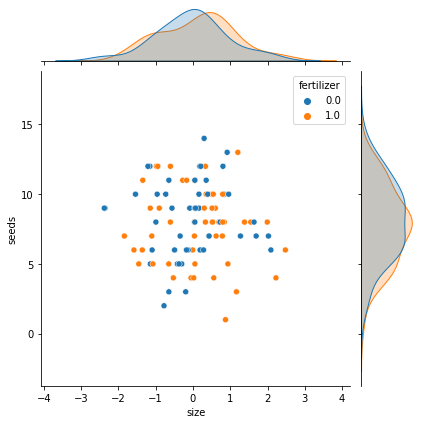

In [14]:
df = pd.DataFrame(np.array([x,made_samples[1],d]).T, columns=["size","seeds","fertilizer"])
sns.jointplot(x="size", y="seeds", data=df,hue="fertilizer")

#### 1000の乱数のセットに対して、帰無仮説と対立仮説の逸脱度の差を求める。

In [15]:
import tqdm # for文の進捗を表示

In [16]:
diffDs = []
for i in tqdm.tqdm(range(1000)):
    y = made_samples[i]
    D0,bs0 = Deviance(LH_poisson0,[0],y,x,d)
    D1,bs1 = Deviance(LH_poisson1,[0,0],y,x,d)
    diffD = D0-D1
    diffDs.append(diffD)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:42<00:00,  6.16it/s]


ヒストグラムで逸脱度の差の分布を確認

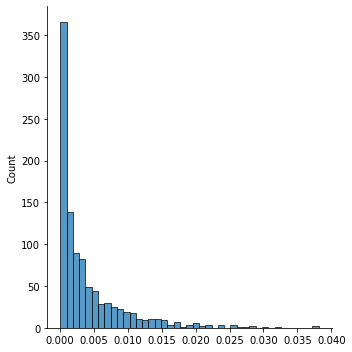

In [17]:
sns.displot(diffDs)

サンプルで求めた帰無仮説と対立仮説の逸脱度の差と優位水準から帰無仮説が棄却できるかどうかを判定する

In [18]:
count = 0
for i in range(1000):
    if diffDs[i] >diff0:count+=1

print("P値:",count,"/1000")

P値: 0 /1000


P値(=0) < α(=0.05)なので、初期のサンプルで求めた逸脱度の差diff0は無視できる多さではない事がわかる。  
よって帰無仮説は棄却される(無に帰す)。

## 第二種の過誤の確率(β)の算出で検定力を確認

#### 対立仮説でデータセットを作成

対立仮説で最尤推定した結果をもとに、100個で1セットの乱数を1000セット作成する

In [19]:
made_samples = []
for i in range(1000):
    made_sample = np.random.poisson(lam=np.exp(bs1[0] + bs1[1]*x),size=sample_number).astype("float")
    made_samples.append(made_sample)

データセットの一部の分布を確認

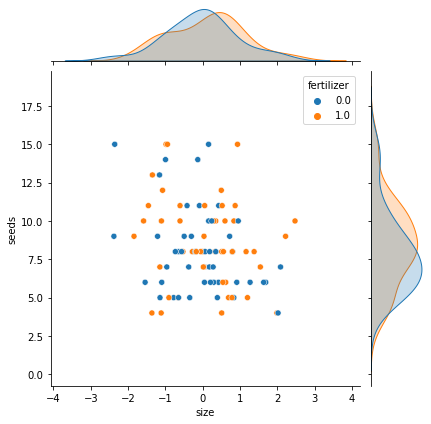

In [20]:
df = pd.DataFrame(np.array([x,made_samples[1],d]).T, columns=["size","seeds","fertilizer"])
sns.jointplot(x="size", y="seeds", data=df,hue="fertilizer")

1000の乱数のセットに対して、帰無仮説と対立仮説の逸脱度の差を求める。

In [21]:
diffDs = []
for i in tqdm.tqdm(range(1000)):
    y = made_samples[i]
    D0,bs0 = Deviance(LH_poisson0,[0],y,x,d)
    D1,bs1 = Deviance(LH_poisson1,[0,0],y,x,d)
    diffD = D0-D1
    diffDs.append(diffD)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:51<00:00,  5.83it/s]


逸脱度の分布からβを計算

In [22]:
count = 0
for i in range(1000):
    if diffDs[i] >diff0:count+=1

print("β:",count,"/1000")

β: 3 /1000


1-β(=0.997)>0.8なので、この検定は正しいと言えそうだ。